# Cas de prédiction du Loto français 

In [1]:
#Import des librairies utiles
import csv
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping

In [2]:
#fonction de scraping des tirages du loto
df_tirage = pd.read_csv('eurodata .csv', sep = ',', usecols=['day','month_year','num0','num1','num2','num3','num4','chance'])
def sorter(num_arr):
    return np.sort(num_arr)
df_tirage[['num0', 'num1', 'num2', 'num3', 'num4']] = df_tirage.apply(lambda row : sorter(row[2:-1]), axis=1, result_type='expand')
dtype={'num':str, 'chance':int}



## Fonction de scraping des tirages

#A noter que plusieurs tirages se sont ajoutés dépuis le 21 : date de rédaction de l'article

In [3]:
#sracping des tirages actuellement disponibles sur le site 

df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()
#suppression  des tirages du super loto( A explorer later )
#df_tirage=df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]

,day,month_year,num0,num1,num2,num3,num4,chance
0,MARDI,05/07/2022,7,10,25,45,48,3
1,VENDREDI,01/07/2022,6,18,24,34,46,12
2,MARDI,28/06/2022,10,35,42,47,48,11
3,VENDREDI,24/06/2022,10,17,28,44,50,12
4,MARDI,21/06/2022,6,23,36,39,47,10


In [4]:
df_tirage=df_tirage.tail(df_tirage.shape[0]-1)


## commentaires: 
* le dernier tirage ici date du 07 décembre, ainsi afin de tester le modèle nous allons rétirer ce tirage du dataset dans la suite
* Par contre on aurait évité de supprimer le tirage du 28 si on voulait prédire le prochain tirage ( celui du samedi 31)

In [5]:
df_tirage=df_tirage.tail(df_tirage.shape[0])# suppression du dernier tirage/à éviter selon le cas 
df_tirage.head()# le dernier tirage devient ici celui du 26

,day,month_year,num0,num1,num2,num3,num4,chance
1,VENDREDI,01/07/2022,6,18,24,34,46,12
2,MARDI,28/06/2022,10,35,42,47,48,11
3,VENDREDI,24/06/2022,10,17,28,44,50,12
4,MARDI,21/06/2022,6,23,36,39,47,10
5,VENDREDI,17/06/2022,19,21,22,31,38,7


## Traitement  des données

In [6]:
df = df_tirage.iloc[::-1]#inversion du dataframe pour placer le dernier tirage en dernière position
df = df[['num0', 'num1', 'num2', 'num3', 'num4','chance']]#sélection des numéros à  traiter

In [7]:
df.tail()# notre tirage du 26 ici devient le dernier de notre dataset afin de pourvoir organiser les data par historique

,num0,num1,num2,num3,num4,chance
5,19,21,22,31,38,7
4,6,23,36,39,47,10
3,10,17,28,44,50,12
2,10,35,42,47,48,11
1,6,18,24,34,46,12


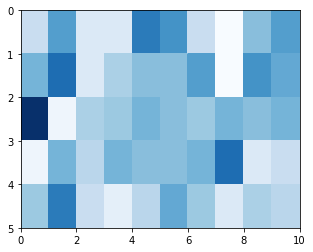

In [8]:


#fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return ((data['chance'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return ((data['chance'].isin(impairs)).astype(int))

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)

# Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
ax = plt.gca() ;  ax.invert_yaxis()
plt.gcf().set_size_inches(5, 4)
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs



#df['sum'] = ((df.num0 + df.num1 + df.num2 + df.num3 + df.num4 +  df.chance1 ) >199).astype(int)


In [9]:
#ajout de la difference entre les numéros(A explorer ASAp)
#for i in range(4):
#   (i,i+1)
#df['diff_{}'.format(i)]=df['num{}'.format(i+1)]-df['num{}'.format(i)]
#application des fonctions sur le dataframe
df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')#calcul des frequences 
df['sum_diff'] = sum_diff(df)#somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df)#verification de nombre pair et impair
df['is_under_24'] = is_under(df, 24)  # Les numeros en dessous de 24 
df['is_under_40'] = is_under(df, 40)# Les numeros en dessous de 40 
df.head(6)

,num0,num1,num2,num3,num4,chance,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
252,21,23,33,35,47,6,1,1,1,1,1,1,252,1,0,0,5,2,4
251,9,15,17,25,40,9,1,1,1,1,1,1,329,0,1,1,4,3,5
250,24,26,32,43,46,6,1,1,1,1,1,2,170,1,0,4,1,1,3
249,5,20,35,41,49,10,1,1,1,1,1,1,550,1,0,1,4,2,3
248,11,32,34,38,47,10,1,1,1,1,2,2,542,1,0,3,2,1,4
247,7,23,30,32,45,5,1,2,1,1,1,1,478,0,1,2,3,2,4


## Modèle et fonction de formatage des données en entrée du LSTM

In [10]:
#capture 3: fonction define model seulement

In [11]:
# j'ai ici défini plusieurs modèles à tester mais pour l'intant je tavaille avec le lstm(fonction : define_model)
# j'ai ici défini window_length à 12 pour apprendre sur 1 mois de données 

#Params du modèle
nb_label_feature=6

UNITS = 200
BATCHSIZE = 30
EPOCH = 1500
# ACTIVATION = "softmax"
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
DROPOUT = 0.1
window_length =36 #12 
number_of_features = df.shape[1]

#Architecture du modèle
def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)

#Moniteur pour stoper le training
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [12]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

## Training

In [13]:
#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)
 

(216, 36, 19)
(216, 6)


* On voit ici que notre dataset d'entrainement après formatage est constitué de 1911 vecteurs contenant chacun 12 tirages où chaque tirage contient 19 features calculés plus haut

* Quant aux labels, on a bien 1911 vecteurs de 6 features soit les 6 numéros de chaque tirages

* Ainsi à partir des 12 tirages précédent on éssaie de prédire le tirage suivant lors de l'entrainement

In [14]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Epoch 00369: early stopping


## Fonction de perte 

In [15]:
#capture 6

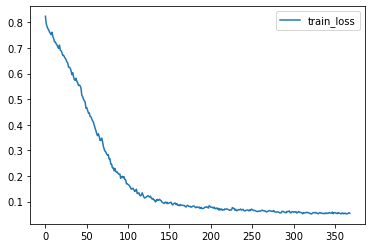

In [16]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Prédiction du tirage suivant le dernier tirage de notre dataset de train

In [17]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

C:\Users\free\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
#prediction
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])